### Imports

In [1]:
from jaxflows.flows import NeuralSplineFlow
from jaxflows.train_utils import train_flow

import matplotlib.pyplot as plt
from sklearn import preprocessing
import jax.numpy as jnp
import numpy as onp
from jax import random
from rnpe.denoise import horseshoe_denoiser_model
from numpyro.infer.hmc import NUTS
from numpyro.infer.mcmc import MCMC

import pandas as pd


/home/dw16200/miniconda3/envs/rnpe_env/lib/python3.9/site-packages/jax/experimental/optimizers.py:28: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  warnings.warn('jax.experimental.optimizers is deprecated, '
/home/dw16200/miniconda3/envs/rnpe_env/lib/python3.9/site-packages/jax/experimental/stax.py:28: FutureWarning: jax.experimental.stax is deprecated, import jax.example_libraries.stax instead
  warnings.warn('jax.experimental.stax is deprecated, '


### Load dataset

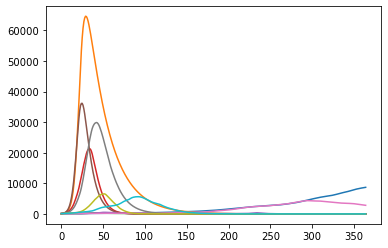

In [46]:
simulations = jnp.load("data/sirsde/simulations.npz")
theta = simulations["theta"]
theta = jnp.array(theta)
x = simulations["x"]
x = jnp.array(x)
plt.plot(jnp.transpose(x[:10]))
plt.show()

### Create misspecification

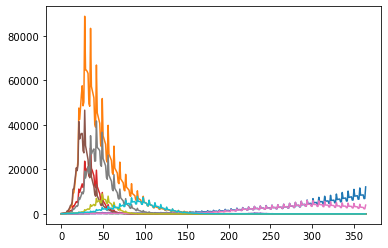

In [3]:
def get_day_idx(days: list):
    weekdays = ["monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday"]
    weekdays = {day: i for i, day in enumerate(weekdays)}
    idxs = []
    for day in days:
        idxs += list(range(weekdays[day], 365, 7))
    return sorted(idxs)

def misspecify(x, multiplier=0.8):
    x = onp.array(x)
    x = x.copy()
    days = ["saturday", "sunday", "monday"]
    sat_idx, sun_idx, mon_idx = [get_day_idx([d]) for d in days]
    mon_idx = mon_idx[1:]
    sat_new = x[:, sat_idx] * multiplier
    sun_new = x[:, sun_idx] * multiplier
    missed_cases = (x[:, sat_idx] - sat_new) + (x[:, sun_idx] - sun_new)
    mon_new = x[:, mon_idx] + missed_cases

    for idx, new in zip([sat_idx, sun_idx, mon_idx], [sat_new, sun_new, mon_new]):
        x[:, idx] = new
    return jnp.array(x)

x_misspecified = misspecify(x)
plt.plot(jnp.transpose(x_misspecified[:10]))
plt.show()

### Calculate summary statistics

In [4]:
# TODO Use vmap
def autocorr_lag1(x):
    x1 = x[:, :-1]
    x2 = x[:, 1:]
    x1_dif = (x1.T - x1.mean(axis=1)).T
    x2_dif = (x2.T - x2.mean(axis=1)).T
    numerator = (x1_dif*x2_dif).sum(axis=1)
    denominator = jnp.sqrt((x1_dif**2).sum(axis=1)*(x2_dif**2).sum(axis=1))
    return numerator/denominator

def i_quantile_day(x, q):
    "Day when q proportion of total infections was reached."
    prop_i = (jnp.cumsum(x, axis=1).T/jnp.sum(x, axis=1)).T
    return jnp.argmax(prop_i > q, axis=1)

def summarise(x):
    summaries = {
        "total_i" : x.sum(axis=1),
        "autocor_lag1" : autocorr_lag1(x),
        "total_weekend_i" : x[:, get_day_idx(["saturday", "sunday"])].sum(axis=1),
        "25_percentile_day" : i_quantile_day(x, 0.25),
        "50_percentile_day" : i_quantile_day(x, 0.5),
        "75_quantile_day" : i_quantile_day(x, 0.75), 
    }
    return pd.DataFrame(summaries)

In [5]:
s = summarise(x)
s_misspecified = summarise(x_misspecified)

In [6]:
s_means, s_stds = s.mean(axis=0), s.std(axis=0)
s = (s-s_means)/s_stds
s_misspecified = (s_misspecified-s_means)/s_stds

### Train marginal likelihood flow

In [11]:
key, flow_key, train_key = random.split(random.PRNGKey(0), 3)
flow = NeuralSplineFlow(flow_key, target_dim=s.shape[1])
flow, losses = train_flow(train_key, flow, jnp.array(s), max_epochs=20)

100%|██████████| 20/20 [01:42<00:00,  5.13s/it, train=-8.41, val=-8.3] 


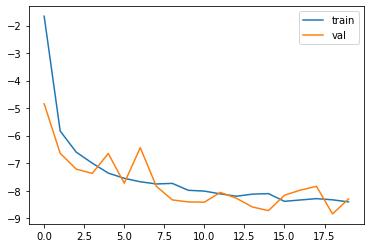

In [22]:
for k, v in losses.items():
    plt.plot(v, label=k)
plt.legend()

### Denoise with MCMC

In [13]:
obs_num = 0
y_obs = jnp.array(s_misspecified)[obs_num]
theta_true = theta[obs_num]
kernel = NUTS(horseshoe_denoiser_model)
mcmc = MCMC(kernel, num_warmup=3000, num_samples=10000)
mcmc.run(random.PRNGKey(42), y_obs, flow.bijection.inverse)  # TODO use propper key here
mcmc.print_summary()

sample: 100%|██████████| 13000/13000 [03:01<00:00, 71.82it/s, 407 steps of size 2.54e-03. acc. prob=0.85]  



                mean       std    median      5.0%     95.0%     n_eff     r_hat
lambdas[0]      3.64     12.60      1.29      0.01      6.47   1589.80      1.00
lambdas[1]  25674.16  55831.58   8697.72     35.44  66910.41    947.21      1.00
lambdas[2]      2.73      7.48      1.06      0.00      5.54   1464.52      1.00
lambdas[3]      2.85     10.97      0.92      0.01      4.89    751.70      1.00
lambdas[4]      2.63      7.43      0.97      0.01      5.40    984.45      1.00
lambdas[5]      2.59     12.27      0.99      0.00      4.41   1110.29      1.00
    tau[0]      0.01      0.03      0.01      0.00      0.03   1178.14      1.00
      z[0]      1.52      0.26      1.61      1.10      1.86    593.89      1.00
      z[1]      1.40      0.27      1.43      0.97      1.84    928.66      1.00
      z[2]      1.93      0.39      2.04      1.39      2.43    510.95      1.00
      z[3]      1.54      0.42      1.55      0.89      2.24    828.11      1.00
      z[4]     -0.09      0

### Plot $\lambda$ samples

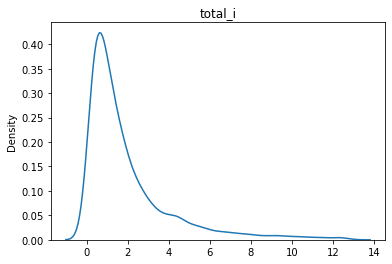

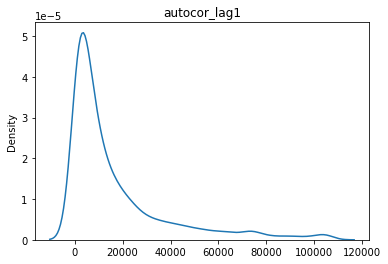

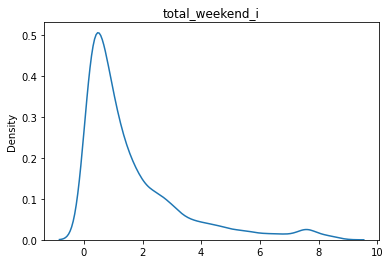

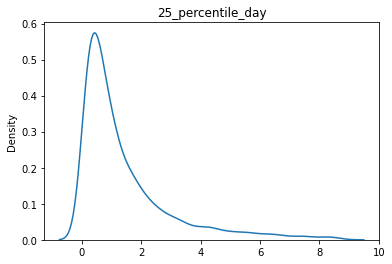

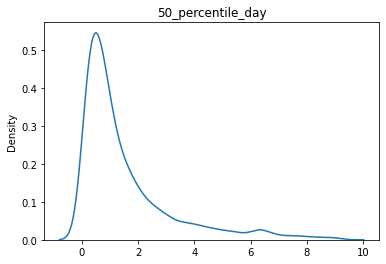

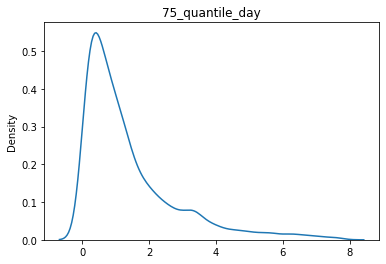

In [18]:
import seaborn as sns

samples = mcmc.get_samples()["lambdas"]
names = list(s)

for name, col in zip(names, jnp.transpose(samples)):
    col = col[col < jnp.quantile(col, 0.95)]  # For better plotting
    sns.kdeplot(col)
    plt.title(name)
    plt.show()

### Posterior inference

In [26]:
key, flow_key, train_key = random.split(random.PRNGKey(0), 3)

posterior_flow = NeuralSplineFlow(
    flow_key,
    target_dim=theta.shape[1],
    condition_dim=s.shape[1])

posterior_flow, losses = train_flow(train_key, posterior_flow, theta, jnp.array(s), max_epochs=20)


100%|██████████| 20/20 [01:15<00:00,  3.80s/it, train=-6.28, val=-6.43]


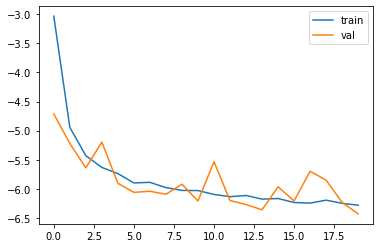

In [27]:
for k, v in losses.items():
    plt.plot(v, label=k)
plt.legend()

### Sample non-robust and robust posterior

In [38]:
robust = mcmc.get_samples()["x"]
n_samples = robust.shape[0]
non_robust = jnp.repeat(jnp.expand_dims(y_obs, 0), n_samples, axis=0)


In [39]:
key, robust_key, non_robust_key = random.split(key, 3)
robust_posterior = posterior_flow.sample(robust_key, n_samples, robust)  # TODO why do we need to specify n and condition! Either should be fine.
non_robust_posterior = posterior_flow.sample(non_robust_key, n_samples, non_robust)  # TODO why do we need to specify n and condition! Either should be fine.

Text(0, 0.5, 'recovery rate (gamma)')

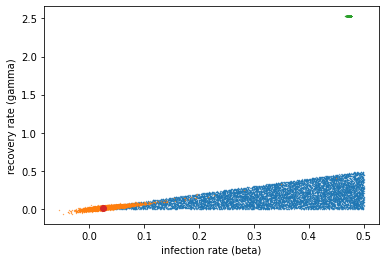

In [52]:
plt.scatter(theta[:n_samples, 0], theta[:n_samples, 1], s=0.1)
plt.scatter(robust_posterior[:, 0], robust_posterior[:, 1], s=0.1)
plt.scatter(non_robust_posterior[:, 0], non_robust_posterior[:, 1], s=0.1)
plt.scatter(theta_true[0], theta_true[1])
plt.xlabel("infection rate (beta)")
plt.ylabel("recovery rate (gamma)")
